In [3]:
import os 
os.getcwd()

'/share/data/analyses/benjamin/Single_cell_project'

# Create image masks with outlines

In [4]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
#from cellpose import utils, io, transforms
import skimage
import cv2
from skimage.measure import label, regionprops
import re
import tifffile as tiff
from tqdm import tqdm
import scipy

In [5]:
import pandas as pd

In [4]:
files = []
import glob, os
#os.chdir('/home/jovyan/share/mikro/RMS/RMS-e02-v01-P014561-RH30-48h/2021-10-29/826/')
folder_path = '/home/jovyan/share/mikro/RMS/RMS-e02-v01-P014561-RH30-48h/2021-10-29/826/'
files = os.listdir(folder_path)
# Filter the files that do not contain "thumb" in their filenames
filtered_files = [file for file in files if "thumb" not in file]
#for file in glob.glob("*w6.png"):
 #   if not file in files:
  #      files.append(file)
files_sorted = sorted(filtered_files)
image_paths = [os.path.join(folder_path, files_sort) for files_sort in files_sorted]

print(len(image_paths),str("images"))

5760 images


## Show example Image

In [5]:
test = os.path.join(folder_path, "RMS-e02-v01-P014561-RH30-48h_A01_s1_w3C284656C-0D63-44D3-8800-344318624A0D.tif")
print(test)

/home/jovyan/share/mikro/RMS/RMS-e02-v01-P014561-RH30-48h/2021-10-29/826/RMS-e02-v01-P014561-RH30-48h_A01_s1_w3C284656C-0D63-44D3-8800-344318624A0D.tif


In [6]:
def image_to_rgb(img0, channels=[0,0]):
    """ image is 2 x Ly x Lx or Ly x Lx x 2 - change to RGB Ly x Lx x 3 """
    img = img0.copy()
    img = img.astype(np.float32)
    if img.ndim<3:
        img = img[:,:,np.newaxis]
    if img.shape[0]<5:
        img = np.transpose(img, (1,2,0))
    if channels[0]==0:
        img = img.mean(axis=-1)[:,:,np.newaxis]
    for i in range(img.shape[-1]):
        if np.ptp(img[:,:,i])>0:
            img[:,:,i] = np.clip(transforms.normalize99(img[:,:,i]), 0, 1)
            img[:,:,i] = np.clip(img[:,:,i], 0, 1)
    img *= 255
    img = np.uint8(img)
    RGB = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
    if img.shape[-1]==1:
        RGB = np.tile(img,(1,1,3))
    else:
        RGB[:,:,channels[0]-1] = img[:,:,0]
        if channels[1] > 0:
            RGB[:,:,channels[1]-1] = img[:,:,1]
    return RGB

In [7]:
first_cell_norm = "/share/data/analyses/benjamin/Single_cell_project/scDINO_RH30/RMS_masks/crops_new/composite_crops_normalized/RMS-e02-v01-P014561-RH30-48h_A02_s5_composite_26.tif"
first_cell = "/share/data/analyses/benjamin/Single_cell_project/scDINO_RH30/RMS_masks/crops_new/composite_crops/RMS-e02-v01-P014561-RH30-48h_A02_s5_composite_26.tif"

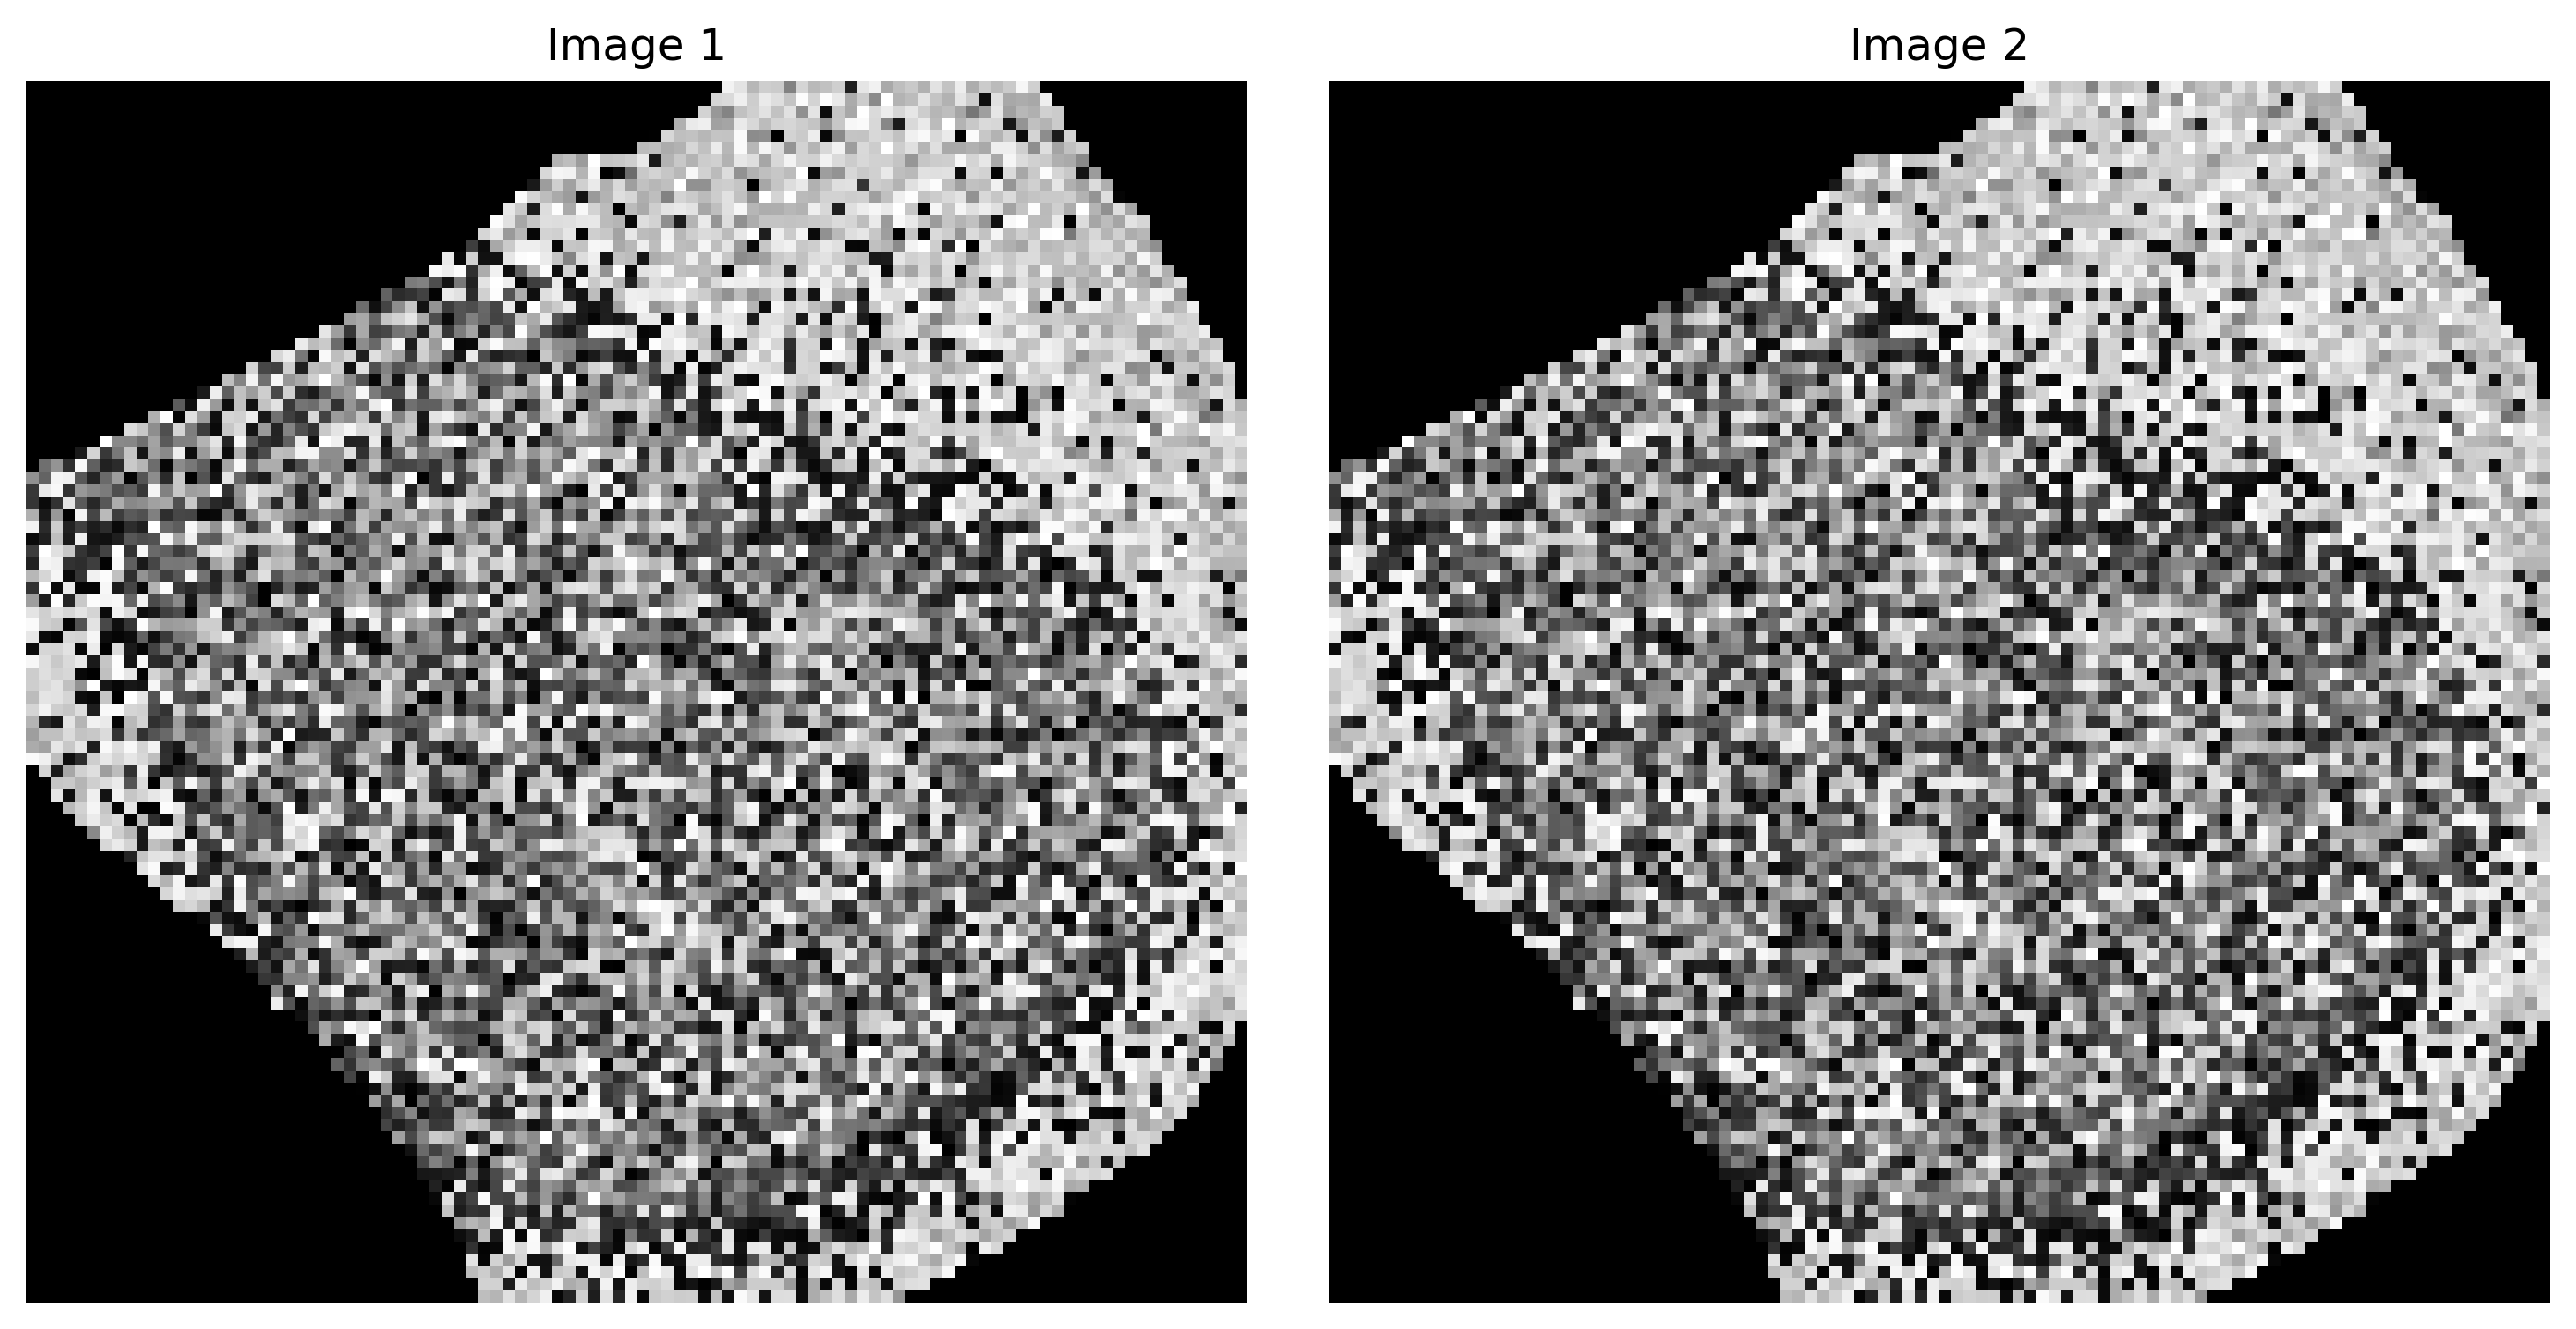

In [8]:
#view 1 image
#img = skimage.io.imread(image_paths[1])

img = skimage.io.imread(first_cell)
img_norm = skimage.io.imread(first_cell_norm)
rgb_image = img[:, :, :1]
rgb_image_n = img_norm[:, :, :1]
img0 = image_to_rgb(rgb_image, channels=[0, 0])
img0_n = image_to_rgb(rgb_image_n, channels=[0, 0])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image in the left subplot
axes[0].imshow(img0)
axes[0].set_title('Image 1')
axes[0].axis('off')

# Plot the second image in the right subplot
axes[1].imshow(img0_n)
axes[1].set_title('Image 2')
axes[1].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# RUN CELLPOSE MODELS

In [9]:
files_cellpose = [string for string in image_paths if "w3" in string]

In [10]:
len(files_cellpose)

1152

In [14]:
from cellpose import models, io
model = models.Cellpose(gpu=True, model_type='cyto')
channels = [[3,2]] * len(files_cellpose)
mask_dict = {}
for chan, filename in tqdm(zip (channels, files_cellpose), total = len(files_cellpose)):
    img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter=150, channels=chan, flow_threshold=0.8, cellprob_threshold=0.00001)
    mask_dict[filename] = masks
    #io.save_masks(img, masks, flows, filename, png = True, tif = True,  savedir ='/share/data/analyses/benjamin/Single_cell_project/RMS_masks/')

  0%|          | 0/1152 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1152/1152 [1:48:22<00:00,  5.64s/it] 


In [15]:
import pickle
import time, os, fnmatch, shutil
t = time.localtime()
timestamp = time.strftime('%b-%d-%Y_%H%M', t)
BACKUP_NAME = ("masks_dictionary_RMS_RH30-" + timestamp)
with open(f"{BACKUP_NAME}.bin", "wb") as f:
    pickle.dump(mask_dict, f)

print("Dictionary saved to binary file.")

Dictionary saved to binary file.


In [11]:
import pickle
file_path = "masks_dictionary_RMS_RH30-Sep-19-2023_1344.bin"

# Load the binary pickle file
with open(file_path, 'rb') as file:
    mask_dict = pickle.load(file)

In [12]:
first_key, first_value = list(mask_dict.items())[1151]
print(first_key, np.unique(first_value.flatten()))

/home/jovyan/share/mikro/RMS/RMS-e02-v01-P014561-RH30-48h/2021-10-29/826/RMS-e02-v01-P014561-RH30-48h_P12_s6_w370BFA0BF-1DF5-4AA7-BAAF-CC578B62D947.tif [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200]


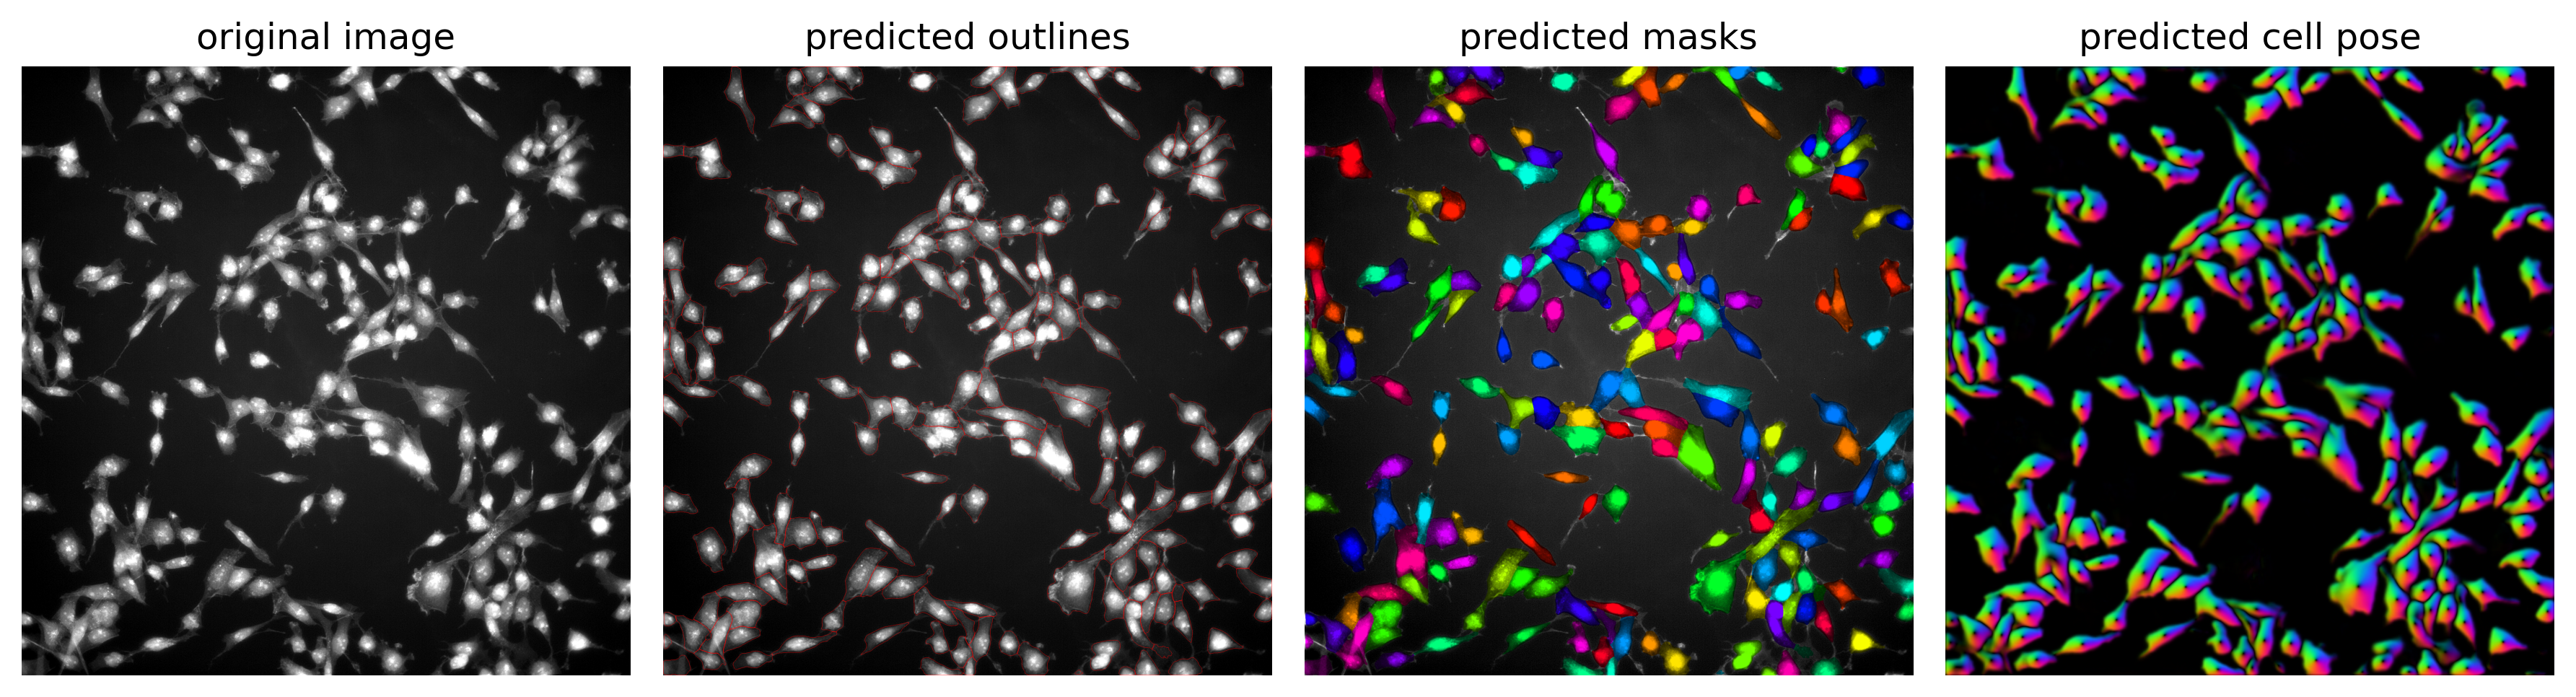

In [17]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

## Extract single cell images from masks

In [13]:
test_file = "RMS-e02-v01-P014561-RH30-48h_A01_s1_w3C284656C-0D63-44D3-8800-344318624A0D.tif"

In [14]:
import tqdm

In [51]:
def find_boxsize(masks):
    #largest_x = -1
    #largest_y = -1
    box_sizes_y = []
    box_sizes_x = []
    for mask in tqdm.tqdm(masks.values()):
        unique_ids = np.unique(mask.flatten())
        for id in unique_ids:
            if id == 0:
                continue
            y, x = np.where(mask == id)
            # Find min and max coordinates
            min_y, max_y = np.min(y), np.max(y)
            min_x, max_x = np.min(x), np.max(x)
            w = max_x-min_x
            h = max_y-min_y
            box_sizes_x.append(w)
            box_sizes_y.append(h)
            #print(w, h)
    return(box_sizes_x, box_sizes_y)

In [52]:
box_sizes_x, box_sizes_y = find_boxsize(mask_dict)

100%|██████████| 1152/1152 [50:45<00:00,  2.64s/it] 


In [86]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def show_box_dist(x_list, y_list):
    sns.set(style="white", font_scale=1.0)
    df1 = pd.DataFrame({'Value': x_list, 'Box': 'x'})
    df2 = pd.DataFrame({'Value': y_list, 'Box': 'y'})
    df = pd.concat([df1, df2])

    # Create the histogram using Seaborn
    sns.histplot(data=df, x='Value', hue='Box', kde=True, element="step")
    plt.title('Distribtion of cell sizes')
    plt.axvline(x=224, color='red', linestyle='--')
    plt.xlabel('Value')
    plt.grid(False)
    plt.ylabel('Frequency')
    sns.despine()
    plt.show()

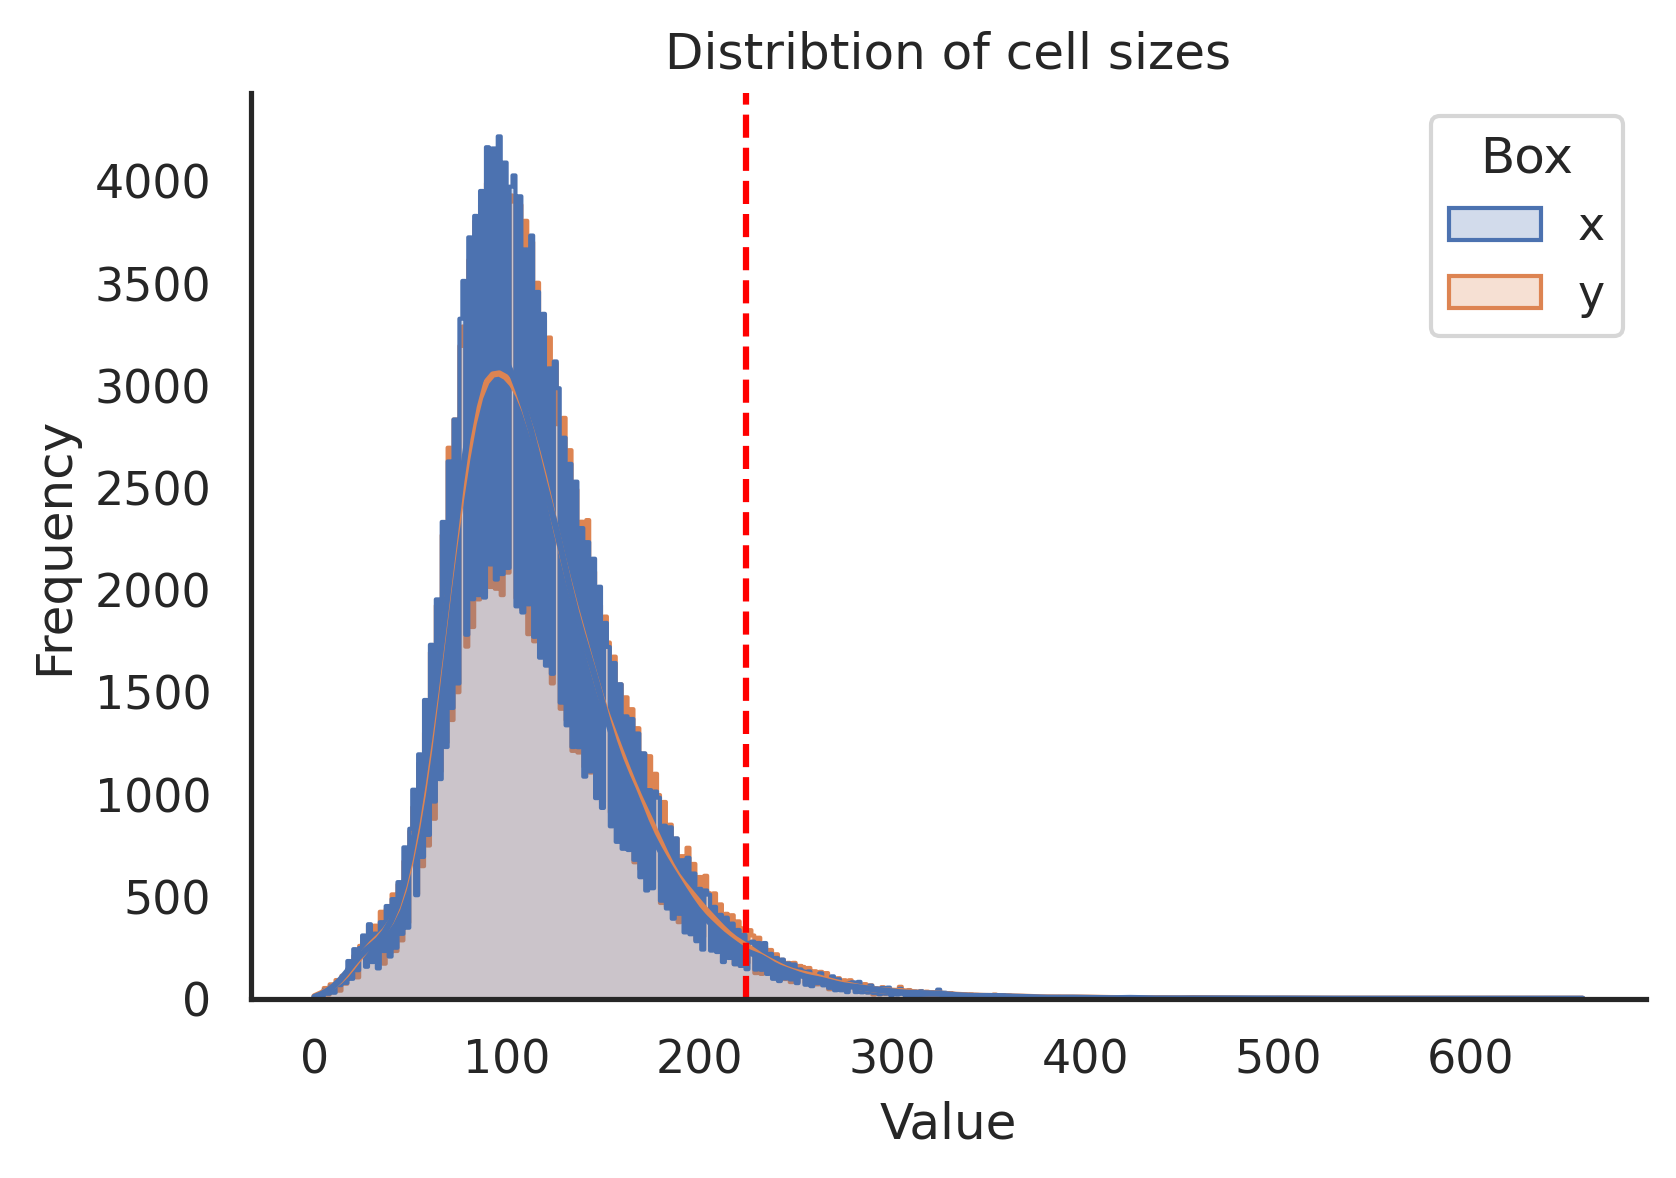

In [87]:
show_box_dist(box_sizes_x, box_sizes_y)

In [15]:
box_size = 224

In [16]:
key_test, value_test = list(mask_dict.items())[10]

In [37]:
generate_single_cell_crops(value_test, key_test, box_size = box_size, normalize = True)

(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 139, 5)
Skipping cell 35 as it is out of frame.
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)
(224, 224, 5)


KeyboardInterrupt: 

In [518]:
for key,value in tqdm(mask_dict.items(), total = len(mask_dict.items()), desc="Processing"):
    generate_single_cell_crops(value, key)

Processing:   0%|          | 0/1152 [00:00<?, ?it/s]<ipython-input-514-ee020814f9db>:103: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(f'{OutputDir}composite_crops_normalized/{first_part}_composite_{cell_id}.tif', composite_crop_out)
Processing: 100%|██████████| 1152/1152 [4:40:02<00:00, 14.59s/it] 


In [19]:
def get_images_from_channels(image_file, image_paths_in):
    channel_files = ["w1", "w2", "w3", "w4", "w5"]
    images = {}
    for i in channel_files:
        file_name = image_file.split("w")[0]
        path_temp = os.path.join(folder_path, file_name) + i
        #print(path_temp)
        path_string = next((string for string in image_paths_in if path_temp in string), None)
        images[i] = skimage.io.imread(path_string)
    return images

In [36]:
def generate_single_cell_crops(mask, image_path, box_size, normalize = False):
    unique_ids = np.unique(mask.flatten())
    images = get_images_from_channels(image_path, image_paths_in = image_paths)
    for cell_id in unique_ids:
            if cell_id == 0:
                continue  # Skip the background
            single_cell_mask = np.where(mask == cell_id, 1, 0)  # Create a binary mask for the current cell
            single_cell_mask = single_cell_mask.copy().astype(np.uint8)
            contours, _ = cv2.findContours(single_cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            crop_mask = np.zeros_like(single_cell_mask).astype(np.uint8)
            cv2.drawContours(crop_mask, contours, -1, 255, thickness=cv2.FILLED)

            w1 = images["w1"]
            w2 = images["w2"]
            w3 = images["w3"]
            w4 = images["w4"]
            w5 = images["w5"]
            w1_mask = np.copy(w1)
            w2_mask = np.copy(w2)
            w3_mask = np.copy(w3)
            w4_mask = np.copy(w4)
            w5_mask = np.copy(w5)

            # Set the rest of the image to 0 where the mask is 0
            w1_mask[crop_mask == 0] = 0
            w2_mask[crop_mask == 0] = 0
            w3_mask[crop_mask == 0] = 0
            w4_mask[crop_mask == 0] = 0
            w5_mask[crop_mask == 0] = 0

            indices = np.where(single_cell_mask != 0)
            if all(len(idx) == 0 for idx in indices):
                print(cell_id)
                continue
            y_min, x_min = np.min(indices, axis=1)
            y_max, x_max = np.max(indices, axis=1)

            # Calculate the center of the bounding box
            # center_z = (z_min + z_max) // 2
            center_y = (y_min + y_max) // 2
            center_x = (x_min + x_max) // 2

            # Calculate the coordinates of the top-left corner of the cropped box
            # box_zmin = center_z - box_size // 2
            box_ymin = center_y - box_size // 2
            box_xmin = center_x - box_size // 2
            # Skipp cells on image border to ensure correct cropping (no half cells)
            if box_ymin < 0:
                continue
            if box_xmin < 0:
                continue

            # Crop the image and mask
            w1_crop = w1_mask[box_ymin : box_ymin + box_size, box_xmin : box_xmin + box_size]
            w2_crop = w2_mask[box_ymin : box_ymin + box_size, box_xmin : box_xmin + box_size]
            w3_crop = w3_mask[box_ymin : box_ymin + box_size, box_xmin : box_xmin + box_size]
            w4_crop = w4_mask[box_ymin : box_ymin + box_size, box_xmin : box_xmin + box_size]
            w5_crop = w5_mask[box_ymin : box_ymin + box_size, box_xmin : box_xmin + box_size]
            cropped_mask = single_cell_mask[box_ymin : box_ymin + box_size, box_xmin : box_xmin + box_size]
            
            if normalize:
                stats = pd.read_csv("/share/data/analyses/benjamin/Single_cell_project/scDINO_RH30/P014561_DMSO_MAD_stats.csv")
                w1_crop = (w1_crop.astype("float") - float(stats.at[0, "DNA"])) / float(stats.at[1, "DNA"])
                w2_crop = (w2_crop.astype("float") - float(stats.at[0, "Mito"])) / float(stats.at[1, "Mito"])
                w3_crop = (w3_crop.astype("float") - float(stats.at[0, "AGP"])) / float(stats.at[1, "AGP"])
                w4_crop = (w4_crop.astype("float") - float(stats.at[0, "RNA"])) / float(stats.at[1, "RNA"])
                w5_crop = (w5_crop.astype("float") - float(stats.at[0, "ER"])) / float(stats.at[1, "ER"])
                composite_crop = np.stack([w1_crop, w2_crop, w3_crop, w4_crop, w5_crop], axis=-1) 
                    
            
            
            
            
            
            composite_crop_out = composite_crop.astype(np.uint8)
            print(composite_crop_out.shape)  
            if w1_crop.shape[0] < box_size or w1_crop.shape[1] < box_size:
                print(f"Skipping cell {cell_id} as it is out of frame.")
                continue

            #fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            #axs[0].imshow(w1_crop)
            #axs[0].set_title('Image 1')
            #axs[1].imshow(w2_crop)
            #axs[1].set_title('Image 2')
            #axs[2].imshow(w3_crop)
            #axs[2].set_title('Image 3')
            #plt.tight_layout()
            #plt.show()

            OutputDir = f'/share/data/analyses/benjamin/Single_cell_project/scDINO_RH30/RMS_masks/crops_224/'
            if not os.path.exists(OutputDir): 
                os.makedirs(OutputDir)
                
            file_string = image_path.split("/")[-1]
            first_part = file_string.split("_w")[0]

            #np.save(f'{OutputDir}/mask-tp-{tpstr}.npy', single_cell_mask)
            #cv2.imwrite(f'{OutputDir}w1_crops/{first_part}_w1_{cell_id}.tif', w1_crop)
            #cv2.imwrite(f'{OutputDir}w2_crops/{first_part}_w2_{cell_id}.tif', w2_crop)
            #cv2.imwrite(f'{OutputDir}w3_crops/{first_part}_w3_{cell_id}.tif', w3_crop)
            #cv2.imwrite(f'{OutputDir}w4_crops/{first_part}_w4_{cell_id}.tif', w4_crop)
            #cv2.imwrite(f'{OutputDir}w5_crops/{first_part}_w5_{cell_id}.tif', w5_crop)
            cv2.imwrite(f'{OutputDir}mask_crops/{first_part}_mask_{cell_id}.tif', cropped_mask)
            tiff.imsave(f'{OutputDir}{first_part}_composite_{cell_id}.tif', composite_crop_out)

In [28]:
os.path.exists('/share/data/analyses/benjamin/Single_cell_project/scDINO_RH30/RMS_masks/crops_224/RMS-e02-v01-P014561-RH30-48h_A02_s5_composite_2.tif')

True

In [13]:
from PIL import Image
from skimage import io
# Open the TIFF image
image_path = '/share/data/analyses/benjamin/Single_cell_project/scDINO_RH30/RMS_masks/crops_224/RMS-e02-v01-P014561-RH30-48h_A02_s5_composite_2.tif'
def check_image_dtype(image_path):
    img = io.imread(image_path)
    print(img.shape)
    print(img.dtype) 
    
check_image_dtype(image_path)


(224, 224, 5)
uint8


## Generate cell centers for metadata

In [13]:
def extract_info(input_string, plate_pattern, well_pattern, site_pattern):
    plate_match = re.search(plate_pattern, input_string)
    well_match = re.search(well_pattern, input_string)
    site_match = re.search(site_pattern, input_string)

    plate = "P" + plate_match.group(1) if plate_match else None
    well = well_match.group(1) if well_match else None
    site = site_match.group(1) if site_match else None

    return plate, well, site

In [48]:
# Function for calculating centerpoints (again)
def calculate_centers(masks):
    slices = scipy.ndimage.find_objects(masks)
    centers = list()
    cells = list()
    for i, si in enumerate(slices):
        if si is not None:
            sr, sc = si
            mask = masks[sr, sc]
            center = scipy.ndimage.center_of_mass(mask)
            center_rounded = (round(center[0]) + sr.start, round(center[1]) + sc.start)
            centers.append(center_rounded)
            cells.append(i)
    return centers, cells

In [135]:
def generate_metadata_single_cell(mask_dict, metadata):
    temp_out = {}
    for key, value in mask_dict.items():
        temp_out[key] = calculate_centers(value)[0]

# Create a list of lists from the dictionary
    data_list = []
    for path, tuples_list in temp_out.items():
        for tup in tuples_list:
            data_list.append([path, tup[0], tup[1]])

# Create the DataFrame from the list of lists
    out = pd.DataFrame(data_list, columns=['Path', 'X_coord', 'Y_coord'])
    out["file_og"] = out['Path'].apply(lambda x: os.path.basename(x))
    
    plate_pattern = r'P(\d+)'
    well_pattern = r'_([A-Za-z0-9]+)_s'
    site_pattern = r'_s(\d+)_'

# Function to extract information from the string
    out[['plate', 'well', 'site']] = out['file_og'].apply(lambda x: pd.Series(extract_info(x, plate_pattern = plate_pattern, well_pattern= well_pattern, site_pattern = site_pattern)))
    #Create metadata columns from file names
    out['cell_no'] = out.groupby(['plate', 'well', 'site']).cumcount() + 1
    
    out['Composite'] = out.apply(lambda row: f"{row['Path'].split('/')[-1].split('_w')[0]}_composite_{row['cell_no']}.tif", axis=1)
    out['DNA'] = out.apply(lambda row: f"{row['Path'].split('/')[-1].split('_w')[0]}_w1_{row['cell_no']}.tif", axis=1)
    out['Mito'] = out.apply(lambda row: f"{row['Path'].split('/')[-1].split('_w')[0]}_w2_{row['cell_no']}.tif", axis=1)
    out['AGP'] = out.apply(lambda row: f"{row['Path'].split('/')[-1].split('_w')[0]}_w3_{row['cell_no']}.tif", axis=1)
    out['RNA'] = out.apply(lambda row: f"{row['Path'].split('/')[-1].split('_w')[0]}_w4_{row['cell_no']}.tif", axis=1)
    out['ER'] = out.apply(lambda row: f"{row['Path'].split('/')[-1].split('_w')[0]}_w5_{row['cell_no']}.tif", axis=1)
    out.drop(columns=['Path'], inplace=True)
    out.rename(columns={'well': 'Metadata_Well'}, inplace=True)

    out_final = pd.merge(out, metadata, on='Metadata_Well', how='inner')
    # Print the resulting DataFrame
    return(out_final)

In [132]:
plate_metadata = pd.read_csv("RMS-e02-v01-P014561-RH30-48h.csv")

In [312]:
metadata_coordinates = generate_metadata_single_cell(mask_dict, plate_metadata)

In [320]:
metadata_coordinates.to_csv("Metadata_Singlecell_Locations_RH30_P014561.csv", index = False)

In [410]:
metadata_DINO = metadata_coordinates.copy()
new_column_names = {'Composite': 'Image_Name', "site": "Site", 'Metadata_Well': 'Well', "Metadata_Site": "Site", "Metadata_cmpdName" : "Treatment", "Metadata_cmpdConc": "Concentration"}
columns_to_drop = ['file_og', 'DNA', "RNA", "ER", "AGP", "Mito", "Metadata_plate_map_name"]

metadata_DINO.rename(columns=new_column_names, inplace=True)
metadata_DINO.drop(columns=columns_to_drop, inplace=True)
print(metadata_DINO)

        X_coord  Y_coord    plate Well Site  cell_no  \
0            34      237  P014561  A01    1        1   
1            49      327  P014561  A01    1        2   
2            75      616  P014561  A01    1        3   
3           115     1269  P014561  A01    1        4   
4            75     1757  P014561  A01    1        5   
...         ...      ...      ...  ...  ...      ...   
195383     2124     1087  P014561  P12    6      196   
195384     2132     1853  P014561  P12    6      197   
195385     2132      983  P014561  P12    6      198   
195386     2146     1645  P014561  P12    6      199   
195387     2150     1474  P014561  P12    6      200   

                                               Image_Name Treatment  \
0       RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_...     blank   
1       RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_...     blank   
2       RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_...     blank   
3       RMS-e02-v01-P014561-RH30-48h_A01_s1

In [411]:
metadata_DINO["channel_width"] = 5

In [412]:
# Create a DataFrame to map group names to target values
group_targets = metadata_DINO['Treatment'].drop_duplicates().reset_index(drop=True)
group_targets = group_targets.reset_index().rename(columns={'index': 'Target'})

# Merge the target values back to the original DataFrame
metadata_DINO = metadata_DINO.merge(group_targets, on='Treatment')

print(metadata_DINO.drop_duplicates())


        X_coord  Y_coord    plate Well Site  cell_no  \
0            34      237  P014561  A01    1        1   
1            49      327  P014561  A01    1        2   
2            75      616  P014561  A01    1        3   
3           115     1269  P014561  A01    1        4   
4            75     1757  P014561  A01    1        5   
...         ...      ...      ...  ...  ...      ...   
195383     1112      164  P014561  M12    4        2   
195384      424      714  P014561  M12    5        1   
195385      691      608  P014561  M12    5        2   
195386      780      643  P014561  M12    5        3   
195387     1104     1543  P014561  M12    5        4   

                                               Image_Name   Treatment  \
0       RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_...       blank   
1       RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_...       blank   
2       RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_...       blank   
3       RMS-e02-v01-P014561-RH30-48

In [413]:
folder_check = 'scDINO_RH30/RMS_masks/crops_new/composite_crops'

# Get the list of files in the folder
folder_files = os.listdir(folder_check)

# Filter DataFrame based on existing files in the folder
metadata_DINO_final = metadata_DINO[metadata_DINO['Image_Name'].isin(folder_files)]

In [447]:
metadata_DINO_final = metadata_DINO_final[~metadata_DINO_final['Image_Name'].isin(wrong_filenames)]

In [448]:
print(metadata_DINO_final)

        X_coord  Y_coord    plate Well Site  cell_no  \
0            34      237  P014561  A01    1        1   
1            49      327  P014561  A01    1        2   
2            75      616  P014561  A01    1        3   
3           115     1269  P014561  A01    1        4   
4            75     1757  P014561  A01    1        5   
...         ...      ...      ...  ...  ...      ...   
195383     1112      164  P014561  M12    4        2   
195384      424      714  P014561  M12    5        1   
195385      691      608  P014561  M12    5        2   
195386      780      643  P014561  M12    5        3   
195387     1104     1543  P014561  M12    5        4   

                                               Image_Name   Treatment  \
0       RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_...       blank   
1       RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_...       blank   
2       RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_...       blank   
3       RMS-e02-v01-P014561-RH30-48

In [449]:
metadata_DINO_final.to_csv("Metadata_DINO_RH30_P014561.csv", index = False)

### Show center points of cells as test

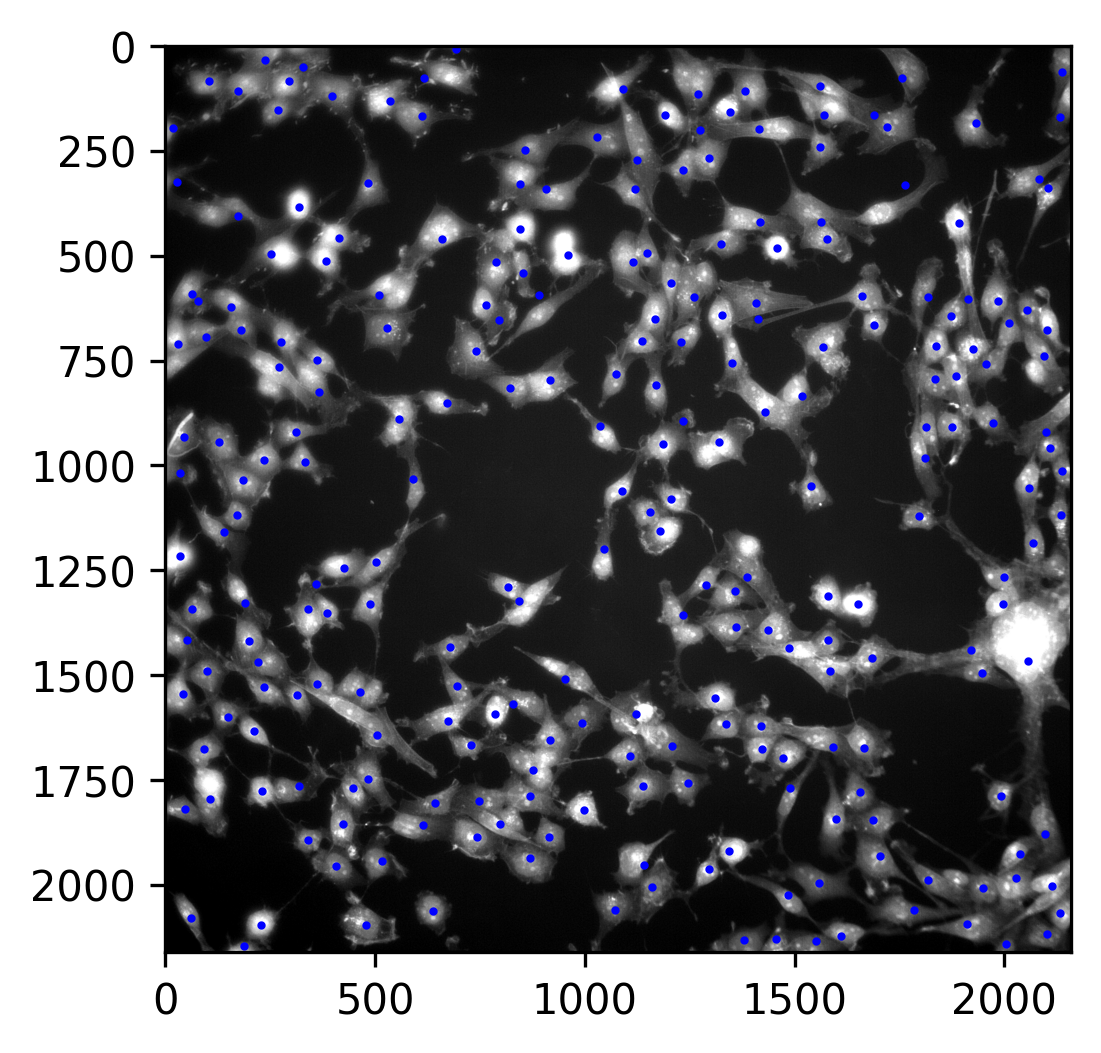

In [339]:
# Load information and calculate center positions
#dat = np.load('_seg.npy', allow_pickle=True).item()
#mask_test = dat['masks']
#image = dat['img']
centers = calculate_centers(test_value)[0]

img_test = skimage.io.imread(test_key, as_gray = True)
img0_test = image_to_rgb(img_test, channels=[0, 0])
# Initialize plot
plt.imshow(img0_test)

# Add blue dots for every cell centra
for center in centers:
    y, x = center
    #if xmin <= x <= xmax and ymin <= y <= ymax:
    plt.plot(x, y, marker = "o", markersize = 1, markeredgecolor = "blue", markerfacecolor = "blue")

# Show plot
plt.show()

## Create data and metadata for Deepprofiler


In [70]:
metadata_RH30_P014561 = pd.read_csv("/share/data/analyses/benjamin/Single_cell_project/Metadata_DeepProfiler_RH30_P014561-Copy1.csv")

In [6]:
data_RH30_P014562 = pd.read_csv("/share/data/analyses/benjamin/RMS_single_cell_features/level4_P014562RH30.csv")
data_RH30_P014563 = pd.read_csv("/share/data/analyses/benjamin/RMS_single_cell_features/level4_P014563RH30.csv")

In [8]:
filter_cols = [col for col in data_RH30_P014562.columns if 'metadata' in col.lower() or 'nuclei_location_center_x' in col.lower() or 'nuclei_location_center_y' in col.lower()]
print(filter_cols)

['Metadata_plate_map_name', 'Metadata_cmpdName', 'Metadata_cmpdConc', 'Metadata_Well', 'Metadata_CellLine', 'Metadata_sample_type', 'Metadata_Site', 'Nuclei_Location_Center_X', 'Nuclei_Location_Center_Y']


In [10]:
metadata_RH30_P014562 = data_RH30_P014562[filter_cols]
metadata_RH30_P014563 = data_RH30_P014563[filter_cols]

In [12]:
import os
import shutil

source_folder = '/home/jovyan/share/mikro/RMS/RMS-e02-v01-P014563-RH30-48h/2021-10-28/821'
destination_folder = '/home/jovyan/share/data/analyses/benjamin/Single_cell_project/full_pictures_RH30_P014563'

for filename in os.listdir(source_folder):
    source_file_path = os.path.join(source_folder, filename)
    if os.path.isfile(source_file_path) and 'thumb' not in filename.lower():
        # Check if the filename contains 'w1', 'w2', etc.
        for channel in ['_w1', '_w2', '_w3', '_w4', '_w5']:
            if channel in filename:
                destination_channel_folder = os.path.join(destination_folder, channel)
                os.makedirs(destination_channel_folder, exist_ok=True)
                shutil.copy(source_file_path, os.path.join(destination_channel_folder, filename))
                break  # Break the loop once the file is moved to the corresponding folder


In [39]:
def find_file(metadata_name, well, site,  search_folder):
    search_name = f"{metadata_name}_{well}_s{site}"  # adjust this format if necessary
    #print(search_name)
    for filename in os.listdir(search_folder):
        if search_name in filename:
            return filename
    return None  # returns None if no file is found

In [56]:
def generate_metadata_deepprofiler(df0, folder):
    images_folder = folder
    df = df0.filter(regex='^(Metadata)').drop_duplicates() 
    df['file_og'] = df.apply(lambda row: find_file(row['Metadata_plate_map_name'], row['Metadata_Well'], int(row['Metadata_Site']), images_folder), axis=1)
# Function to extract the file paths for 'w1' to 'w5'
    def extract_file_paths(row):
        file_prefix = str(row['file_og']).split('_w')[0] + '_w'
        file_paths = {}
        for i in range(1, 6):
            pat = str(file_prefix) + str(i)
            pattern = pat[pat.find('R'):]
            matching_files = [file for file in os.listdir(images_folder) if re.search(pattern, file) and not "thumb" in file] 
            if matching_files:
                file_paths[f'w{i}'] = matching_files[0]
            else:
                file_paths[f'w{i}'] = None
        return pd.Series(file_paths)

    # Group by 'well' and 'site', and apply the extract_file_paths function to get the new columns
    file_paths_df = df.groupby(['Metadata_Well', 'Metadata_Site']).apply(extract_file_paths)

    # Merge the original DataFrame with the file paths DataFrame
    merged_df = df.merge(file_paths_df, left_on=['Metadata_Well', 'Metadata_Site'], right_on=['Metadata_Well', 'Metadata_Site'])

    # Drop duplicates and keep only one row per 'well' and 'site' combination
    merged_df.drop_duplicates(subset=['Metadata_Well', 'Metadata_Site'], keep='first', inplace=True)
    merged_df.rename(columns={'site': 'Metadata_Site', "w1": "DNA", "w2" : "Mito", "w3" : "AGP", "w4" : "RNA", "w5" : "ER"}, inplace=True)
    merged_df['Metadata_Site'] = 's' + merged_df['Metadata_Site'].astype(str)
    merged_df.drop("file_og", axis=1, inplace=True)
    # Reorder the columns if needed
    #merged_df = merged_df[['Metadata_Well', 'plate', 'site', 'cell', 'w1', 'w2', 'w3', 'w4', 'w5']]
    
    
    return(merged_df)

In [57]:
metadata_DeepProfiler_P014562_RH30 =generate_metadata_deepprofiler(metadata_RH30_P014562, "/home/jovyan/share/mikro/RMS/RMS-e02-v01-P014562-RH30-48h/2021-10-29/823")

In [59]:
metadata_DeepProfiler_P014563_RH30 =generate_metadata_deepprofiler(metadata_RH30_P014563, "/home/jovyan/share/mikro/RMS/RMS-e02-v01-P014563-RH30-48h/2021-10-28/821")

In [72]:
metadata_DeepProfiler_P014562_RH30["Metadata_plate"] = "P014562"
metadata_DeepProfiler_P014563_RH30["Metadata_plate"] = "P014563"

In [80]:
metadata_deepprofiler_RH30_all = pd.concat([metadata_RH30_P014561, metadata_DeepProfiler_P014562_RH30, metadata_DeepProfiler_P014563_RH30], axis = 0)

In [88]:

metadata_deepprofiler_RH30_all['Metadata_Site'] = metadata_deepprofiler_RH30_all['Metadata_Site'].str.split('.').str[0]
metadata_deepprofiler_RH30_all

Metadata_Well Metadata_Site       Metadata_plate_map_name  \
0             G08            s1  RMS-e02-v01-P014561-RH30-48h   
1             M06            s3  RMS-e02-v01-P014561-RH30-48h   
2             A04            s2  RMS-e02-v01-P014561-RH30-48h   
3             F03            s1  RMS-e02-v01-P014561-RH30-48h   
4             F08            s1  RMS-e02-v01-P014561-RH30-48h   
..            ...           ...                           ...   
846           L04            s2  RMS-e02-v01-P014563-RH30-48h   
847           L04            s3  RMS-e02-v01-P014563-RH30-48h   
848           L04            s4  RMS-e02-v01-P014563-RH30-48h   
849           L04            s5  RMS-e02-v01-P014563-RH30-48h   
850           L04            s6  RMS-e02-v01-P014563-RH30-48h   

        Metadata_cmpdName   Metadata_cmpdNameConc Metadata_sample_type  \
0              Romidepsin            Romidepsin_5                  trt   
1    Dequalinium Chloride  Dequalinium Chloride_1                  trt   
2                   blank                   blank               negcon   
3               Niraparib             Niraparib_1                  trt   
4              Plerixafor            Plerixafor_1                  trt   
..                    ...                     ...                  ...   
846             YOHIMBINE                     NaN                  trt   
847             YOHIMBINE                     NaN                  trt   
848             YOHIMBINE                     NaN                  trt   
849             YOHIMBINE                     NaN                  trt   
850             YOHIMBINE                     NaN                  trt   

     Metadata_cmpdConc Metadata_CellLine  \
0                    5              RH30   
1                    1              RH30   
2                    0              RH30   
3                    1              RH30   
4                    1              RH30   
..                 ...               ...   
846                  5              RH30   
847                  5              RH30   
848                  5              RH30   
849                  5              RH30   
850                  5              RH30   

                                                   DNA  \
0    RMS-e02-v01-P014561-RH30-48h_G08_s1_w112F12067...   
1    RMS-e02-v01-P014561-RH30-48h_M06_s3_w18E98D47D...   
2    RMS-e02-v01-P014561-RH30-48h_A04_s2_w187E9CEEF...   
3    RMS-e02-v01-P014561-RH30-48h_F03_s1_w190529A60...   
4    RMS-e02-v01-P014561-RH30-48h_F08_s1_w14AF7B3D2...   
..                                                 ...   
846  RMS-e02-v01-P014563-RH30-48h_L04_s2_w126C254E8...   
847  RMS-e02-v01-P014563-RH30-48h_L04_s3_w1D984DEBB...   
848  RMS-e02-v01-P014563-RH30-48h_L04_s4_w103916833...   
849  RMS-e02-v01-P014563-RH30-48h_L04_s5_w1725038DE...   
850  RMS-e02-v01-P014563-RH30-48h_L04_s6_w136E039F2...   

                                                  Mito  \
0    RMS-e02-v01-P014561-RH30-48h_G08_s1_w25CD243CC...   
1    RMS-e02-v01-P014561-RH30-48h_M06_s3_w2CF5DA7AC...   
2    RMS-e02-v01-P014561-RH30-48h_A04_s2_w2FFE8FCF7...   
3    RMS-e02-v01-P014561-RH30-48h_F03_s1_w26CBC1856...   
4    RMS-e02-v01-P014561-RH30-48h_F08_s1_w206AB93D4...   
..                                                 ...   
846  RMS-e02-v01-P014563-RH30-48h_L04_s2_w2C54930DA...   
847  RMS-e02-v01-P014563-RH30-48h_L04_s3_w2E9124E94...   
848  RMS-e02-v01-P014563-RH30-48h_L04_s4_w292A23E06...   
849  RMS-e02-v01-P014563-RH30-48h_L04_s5_w2A9D237D3...   
850  RMS-e02-v01-P014563-RH30-48h_L04_s6_w2D6D0E2F4...   

                                                   AGP  \
0    RMS-e02-v01-P014561-RH30-48h_G08_s1_w3D4994ED4...   
1    RMS-e02-v01-P014561-RH30-48h_M06_s3_w3DCCB2C60...   
2    RMS-e02-v01-P014561-RH30-48h_A04_s2_w3AF85AEB1...   
3    RMS-e02-v01-P014561-RH30-48h_F03_s1_w3D82ABD12...   
4    RMS-e02-v01-P014561-RH30-48h_F08_s1_w3CC26A426...   
..                                                 ...   
846  

In [74]:
metadata_DeepProfiler_P014563_RH30.to_csv('metadata_DeepProfiler_P014563_RH30.csv', index=False)

In [76]:
def generate_locations_deepprofiler(meta_centers, folder):
    output_folder = folder
    os.makedirs(output_folder, exist_ok=True)

# Group the data by 'well' and 'site' and save each group as a separate CSV file
    grouped = meta_centers.groupby(['Metadata_Well', 'Metadata_Site'])
    for group_name, group_data in grouped:
        well, site = group_name
        filename = f"{well}-s{site}-Nuclei.csv"
        file_path = os.path.join(output_folder, filename)
        group_data['Nuclei_Location_Center_X'] = group_data['Nuclei_Location_Center_X'].astype(int)
        group_data['Nuclei_Location_Center_Y'] = group_data['Nuclei_Location_Center_Y'].astype(int)
        #group_data.rename(columns={'X_coord': 'Nuclei_Location_Center_X', 'Y_coord': 'Nuclei_Location_Center_Y'}, inplace=True) 
        group_data[['Nuclei_Location_Center_X','Nuclei_Location_Center_Y']].to_csv(file_path, index=False)

In [79]:
generate_locations_deepprofiler(metadata_RH30_P014563,'/share/data/analyses/benjamin/Single_cell_project/DeepProfiler_data_RH30_P014563/locations/')

### Add train test split to metadata for Deepprofiler

In [342]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Sample DataFrame

# Split the dataset while maintaining balanced classes based on the 'Treatment' column
train_df, val_df = train_test_split(metadata_deepprofiler, test_size=0.3, stratify=metadata_deepprofiler['Metadata_cmpdName'], random_state=42)

# Create a new column 'Split' where 1 indicates training and 0 indicates validation
train_df['Metadata_Split'] = 1
val_df['Metadata_Split'] = 0

# Combine the training and validation sets


In [354]:
final_df = pd.read_csv("Metadata_DeepProfiler_RH30_P014561.csv")

In [362]:
final_df.to_csv('Metadata_DeepProfiler_RH30_P014561_new.csv', index=False)

In [355]:
final_df['DNA'] = 'P014561/' + final_df['DNA']
final_df['RNA'] = 'P014561/' + final_df['RNA']
final_df['AGP'] = 'P014561/' + final_df['AGP']
final_df['Mito'] = 'P014561/' + final_df['Mito']
final_df['ER'] = 'P014561/' + final_df['ER']

In [359]:
final_df['Metadata_Site'] = final_df['Metadata_Site'] + ".0"

In [361]:
final_df.rename(columns={'Metadata_plate': 'Metadata_Plate'}, inplace=True)

### Check datatype pictures

In [ ]:
import numpy as np
from skimage import io

# Load an image using skimage
folder_path = '/home/jovyan/share/data/analyses/benjamin/Single_cell_project/scDINO_RH30/RMS_masks/crops_224/'
#image_array = io.imread(image_path)

# Check the data type of the NumPy array
#data_type = image_array.dtype


def check_image_dtype(image_path):
    try:
        img = io.imread(image_path)
        return img.dtype == np.uint8
    except Exception:
        return False

image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]

uint8_images = [image_path for image_path in image_paths if check_image_dtype(image_path)]

print("Number of uint8 images:", len(uint8_images))


In [39]:
import os
import numpy as np
from skimage import io
import concurrent.futures

folder_path = '/home/jovyan/share/data/analyses/benjamin/Single_cell_project/scDINO_RH30/RMS_masks/crops_new/composite_crops/'

def check_image_dtype(image_path):
    try:
        img = io.imread(image_path)
        return img.dtype == np.uint8
    except Exception:
        return False

def process_image(image_path):
    if check_image_dtype(image_path):
        return image_path
    else:
        return None

image_paths = [os.path.join(folder_path, entry.name) for entry in os.scandir(folder_path) if entry.is_file()]

# Set the number of concurrent workers based on your system's CPU cores
num_workers = os.cpu_count()

with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    uint8_images = list(filter(None, executor.map(process_image, image_paths)))

print("Number of uint8 images:", len(uint8_images))


In [444]:
# Convert both lists to sets and find the difference
wrong_files = list(set(image_paths) - set(uint8_images))

In [446]:
wrong_filenames = [os.path.basename(path) for path in wrong_files]

print("File names:", wrong_filenames)

File names: ['RMS-e02-v01-P014561-RH30-48h_A01_s2_composite_91.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_250.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_252.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s2_composite_75.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_126.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_251.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_79.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_40.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_6.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_121.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_132.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_249.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_248.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_18.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_253.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s2_composite_79.tif', 'RMS-e02-v01-P014561-RH30-48h_A01_s1_composite_245.tif', 'RMS-e02-v01-P014561-RH30-

In [416]:
image_array.shape

(100, 100, 5)

In [419]:
from torchvision import transforms, utils
import torchvision
t = torchvision.transforms.ToTensor()

In [426]:
def fold_channels(image, channel_width, mode="ignore"):
    # Expected input image shape: (h, w * c)
    # Output image shape: (h, w, c)
    #output = np.reshape(image, (image.shape[0], channel_width, -1), order="F")
    output = image
    if mode == "ignore":
        # Keep all channels
        pass
    elif mode == "drop":
        # Drop mask channel (last)
        output = output[:, :, 0:-1]
    elif mode == "apply":
        # Use last channel as a binary mask
        mask = output["image"][:, :, -1:]
        output = output[:, :, 0:-1] * mask

    return t(output)

In [427]:
fold_channels(image_array, 5).shape

torch.Size([5, 100, 100])